In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    '''计算二维互相关运算'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [4]:
X = torch.ones((6, 8))
X[:, 2: 6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
K = torch.tensor([[1.0, -1.0]]) 
# 当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [6]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
corr2d(X.t(), K) # 这个卷积核 K 只可以检测垂直边缘，无法检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
# 构造一个二维卷积层，它具有 1 个输出通道和形状为 (1, 2) 的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)
# conv2d = Conv2D((1, 2))

# 四维输入格式和输入格式
# （批量大小，通道，高度，宽度）
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))


for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

batch 2, loss 7.740
batch 4, loss 1.300
batch 6, loss 0.219
batch 8, loss 0.037
batch 10, loss 0.006


In [9]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9841, -0.9870]])

In [10]:
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维度
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape) # 批量大小和通道数都是 1
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1) # 每边填充 1 列/行
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [13]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

In [14]:
def corr2d_multi_in(X, K):
    # 先遍历 X 和 K 的第 0 个维度（输入通道维度），再把他们加在一起
    return sum(corr2d(x, k) for x, k in zip(X, K))

In [15]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [16]:
def corr2d_multi_in_out(X, K):
    # 迭代 K 的第 0 个维度，每次都对输入 X 执行多输入通道互相关运算
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [17]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [18]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [19]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [20]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

In [21]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [22]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [23]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [24]:
X = torch.arange(16, dtype=d2l.float32).reshape((1, 1, 4, 4))
# 前两个维度是样本数和通道数
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [25]:
pool2d = nn.MaxPool2d(3) # 窗口大小 3 x 3，步幅也是 3
pool2d(X)

tensor([[[[10.]]]])

In [26]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [27]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [28]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [29]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
    
net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), # 输入通道，输出通道
    #nn.Sigmoid(),
    nn.ReLU(),
    #nn.AvgPool2d(kernel_size=2, stride=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), # 保持批量数不变，将后面几个维度平铺
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    #nn.ReLU(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    #nn.ReLU(),
    nn.Linear(84, 10)
)

In [30]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [31]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [13]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    '''使用 GPU 计算模型在数据集上的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval() # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测数量
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # BERT 微调所需（之后介绍）
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [14]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    '''用 GPU 训练模型'''
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确数量之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) # 交叉熵损失会自动取平均
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.216, train acc 0.919, test acc 0.872
12699.2 examples/sec on cuda:0


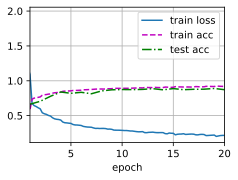

In [34]:
lr, num_epochs = 0.9, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [35]:
net = nn.Sequential(
    # 这里，我们使用一个 11*11 的更大窗口来捕捉对象
    # 同时，步幅为 4，以减少输出的高度和宽度
    # 另外，输出通道的数目远大于 LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为 2 来使得输入和输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口
    # 除了最后的卷积层，输出通道的数量进一步增加
    # 在前两个卷积层之后，不用汇聚层来减少输入的高度和维度
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里全连接层的输出数量是 LeNet 中的好几倍，使用 Dropout 层来减轻过度拟合
    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层，由于这里使用 Fashion-MNIST，所以类别数为 10
    nn.Linear(4096, 10)
)

In [36]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t', X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

In [37]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

KeyboardInterrupt: 

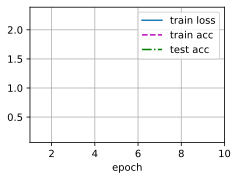

In [38]:
lr, num_epochs = 0.01, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [39]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [40]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks,
        nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [42]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.174, train acc 0.936, test acc 0.921
309.0 examples/sec on cuda:0


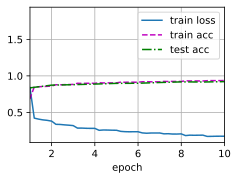

In [44]:
# ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [47]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU()
    )

In [51]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是 10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)), # 指定输出形状：（批量大小，通道数-10，1，1）
    # 将四维的输出转成二维的输出，其形状为（批量大小，10）
    nn.Flatten()
)

In [50]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.586, train acc 0.781, test acc 0.773
394.8 examples/sec on cuda:0


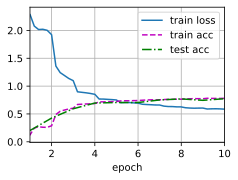

In [53]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [12]:
def predict_ch6(net, test_iter, n=6):
    '''预测标签'''
    for X, y in test_iter:
        X = X.to(d2l.try_gpu())
        y = y.to(d2l.try_gpu())
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    X = X.cpu()
    d2l.show_images(X[0: n].reshape((n, 96, 96)), 1, n, titles=titles[0: n])

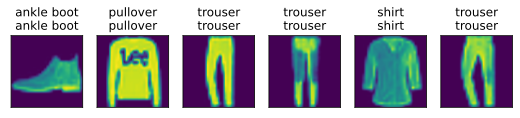

In [77]:
from torch.nn import functional as F
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
predict_ch6(net, test_iter)

In [60]:
class Inception(nn.Module):
    # `c1`--`c4` 是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路 1，单 1 x 1 卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路 2，1 x 1 卷积层后接 3 x 3 卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路 3，1 x 1 卷积层后接 5 x 5 卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路 4，3 x 3 最大汇聚层后接 1 x 1 卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结
        return torch.cat((p1, p2, p3, p4), dim=1)

In [61]:
# 第一个模块，64 通道的 7 x 7 卷积层
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 第二个模块，第一个卷积层是 64 通道 1 x 1，第二个卷积层通道数量增加三倍，3 x 3，对应于 Inception 块中的第二条路径
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 第三个模块，串联两个完整的 Inception 块
# 第一个块的输出通道数为 64 + 128 + 32 + 32 = 256
# 第二个块的输出通道数为 128 + 192 + 96 + 64 = 480
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 第四个模块，串联五个完整的 Inception 块
# 第一个块的输出通道数为 192 + 208 + 48 + 64 = 512
# 第二个块的输出通道数为 160 + 224 + 64 + 64 = 512
# 第三个块的输出通道数为 128 + 256 + 64 + 64 = 512
# 第四个块的输出通道数为 112 + 288 + 64 + 64 = 528
# 第五个块的输出通道数为 256 + 320 + 128 + 128 = 832
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 第五个模块，串联两个完整的 Inception 块
# 第一个块的输出通道数为 256 + 320 + 128 + 128 = 832
# 第二个块的输出通道数为 384 + 384 + 128 + 128 = 1024
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

net = nn.Sequential(
    b1,
    b2,
    b3,
    b4,
    b5,
    nn.Linear(1024, 10) # 再接一个输出个数为标签类别数的全连接层
)

In [62]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.241, train acc 0.907, test acc 0.880
447.3 examples/sec on cuda:0


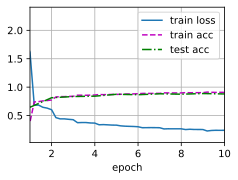

In [64]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [25]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维度上的均值和方差
            # 这里不需要 keepdim=True
            # X 与它们相减时就是在 axis=1 下进行，即每个特征的值减去该特征在所有
            # 样本中的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积的情况，计算通道维度上（axis=1）的均值和方差
            # 这里我们需要保持 x 的形状以便后面可以做广播运算
            # 此时 mean 和 var 都是每个通道的均值和方差
            # X 与它们相减广播后就是每个通道的元素减去所属通道的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [26]:
class BatchNorm(nn.Module):
    # `num_features`: 全连接层的输出数量或卷积层的输出通道数
    # `num_dims`: 2 表示全连接层，4 表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为 1 和 0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为 0 和 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        # 如果 `X` 不再内存上，将 `moving_mean` 和 `moving_var`
        # 复制到 `X` 所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的 `moving_mean` 和 `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [36]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.247, train acc 0.909, test acc 0.855
18021.5 examples/sec on cuda:0


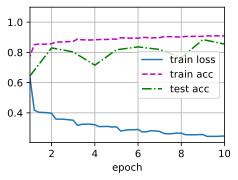

In [38]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [40]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,)), net[1].gamma, net[1].beta, net[1].gamma.shape, net[1].beta.shape

(tensor([1.4107, 2.4884, 2.3069, 1.0664, 1.4528, 1.8853], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.0602,  2.0516,  0.0877, -0.7701, -0.6645, -0.3026], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 Parameter containing:
 tensor([[[[1.4107]],
 
          [[2.4884]],
 
          [[2.3069]],
 
          [[1.0664]],
 
          [[1.4528]],
 
          [[1.8853]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[[[ 0.0602]],
 
          [[ 2.0516]],
 
          [[ 0.0877]],
 
          [[-0.7701]],
 
          [[-0.6645]],
 
          [[-0.3026]]]], device='cuda:0', requires_grad=True),
 torch.Size([1, 6, 1, 1]),
 torch.Size([1, 6, 1, 1]))

In [30]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(256, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)    

loss 0.245, train acc 0.910, test acc 0.863
29073.3 examples/sec on cuda:0


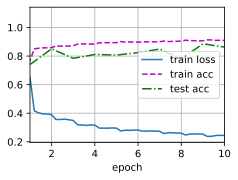

In [31]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [4]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [5]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [7]:
# 后续的模块
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block: 
            # 如果是第一个模块的第一块，则不需要改变通道数，也不需要减半高宽；
            # 后续模块的第一块都需要将通道数翻倍，并且减半高宽
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [8]:
# 这里每个模块使用 2 个残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [9]:
net = nn.Sequential(
    b1,
    b2,
    b3,
    b4,
    b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10)
)

In [10]:
X = torch.rand(size=(1, 1, 224, 224))

In [11]:
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.019, train acc 0.995, test acc 0.916
560.5 examples/sec on cuda:0


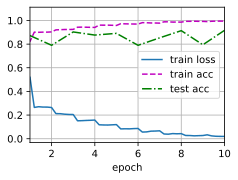

In [15]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

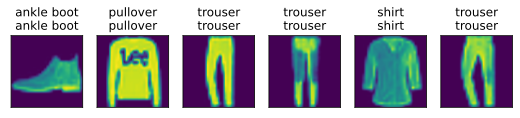

In [16]:
predict_ch6(net, test_iter)

In [17]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [18]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [19]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [20]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [21]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [22]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [27]:
# `num_channels` 为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 加上上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个过渡层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels //= 2

In [28]:
net = nn.Sequential(
    b1,
    *blks,
    nn.BatchNorm2d(num_channels),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

loss 0.148, train acc 0.946, test acc 0.889
710.1 examples/sec on cuda:0


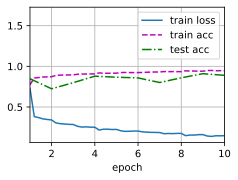

In [29]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())